# Required Libraries

In [69]:
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV

### Functions for Utility

In [79]:
def plot_learning_curve(clf, title):
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, 
                                                            Y, 
                                                            cv=10, 
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(.1, 1., 10), 
                                                            verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")

    # Plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,  alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.legend(loc="best")

### Loading Data

In [13]:
df_sales = pd.read_csv("sales.txt", sep=";")
df_article = pd.read_csv("article_attributes.txt", sep=";")
df_all = pd.merge(df_sales, df_article, left_on='article', right_on='article',how='left')

col = df_all.columns.tolist()
col.remove("retailweek")

date_idx = pd.DatetimeIndex(df_all.retailweek.values.tolist(), name="date")

df_all_ts = pd.DataFrame(data=df_all[col].values.tolist(), index=date_idx, columns=col)
df_all_ts.sort_index(inplace=True)

countries = df_all_ts.country.unique()

### Prepairing Data for ML

In [9]:
df_tmp = df_all_ts.copy()
df_tmp['date'] = df_all_ts.index
df_tmp = df_tmp.dropna()

def encode(x):
    if (x.dtype is np.dtype('O') and x.name != 'sales') or  x.name == 'date':
        return x.astype('category').cat.codes

    return x

df_tmp = df_tmp.apply(encode)

x_col = df_tmp.columns.values[df_tmp.columns.values != 'sales']

X = df_tmp[x_col].values
Y = df_tmp['sales'].values

display(X)
display(Y)

array([[   2.  ,    0.  ,   31.95, ...,   79.  ,   79.  ,    0.  ],
       [   0.  ,  191.  ,   33.95, ...,  230.  ,  133.  ,    0.  ],
       [   1.  ,  425.  ,  135.95, ...,  205.  ,  205.  ,    0.  ],
       ..., 
       [   0.  ,  315.  ,   29.95, ...,  230.  ,  133.  ,  122.  ],
       [   2.  ,  313.  ,   38.95, ...,  145.  ,  145.  ,  122.  ],
       [   2.  ,  475.  ,   63.95, ...,   76.  ,   57.  ,  122.  ]])

array([ 62,  13, 191, ..., 115,  28, 109])

### DecisionTreeRegressor: Checking Accuracy

In [76]:
dsr = DecisionTreeRegressor(random_state = 0, min_samples_split = 15,  max_depth = 10)

scores = cross_val_score(dsr, X, Y, cv = 15)
display(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([ 0.04788004,  0.07544803,  0.00714828, -0.00759725,  0.08298516,
        0.02820429,  0.07369268,  0.07530445,  0.02734506,  0.07899602,
       -0.00674157,  0.03545239, -0.05407309,  0.01216358, -0.23055085])

Accuracy: 0.02 (+/- 0.15)


### RandomForestRegressor : Checking Accuracy

In [75]:
rfr = RandomForestRegressor(n_estimators = 10)

scores = cross_val_score(rfr, X, Y, cv = 10)
display(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([-0.03825163, -0.30073245, -0.00790191, -0.25698855,  0.03972976,
       -0.14100065, -0.053868  , -0.12250452, -0.15077036, -1.15388331])

Accuracy: -0.22 (+/- 0.66)


### Training and Testing

In [77]:
dsr.fit(X, Y)
pre_y_by_dsr = dsr.predict(X)

rfr.fit(X, Y)
pre_y_by_rfr = rfr.predict(X)

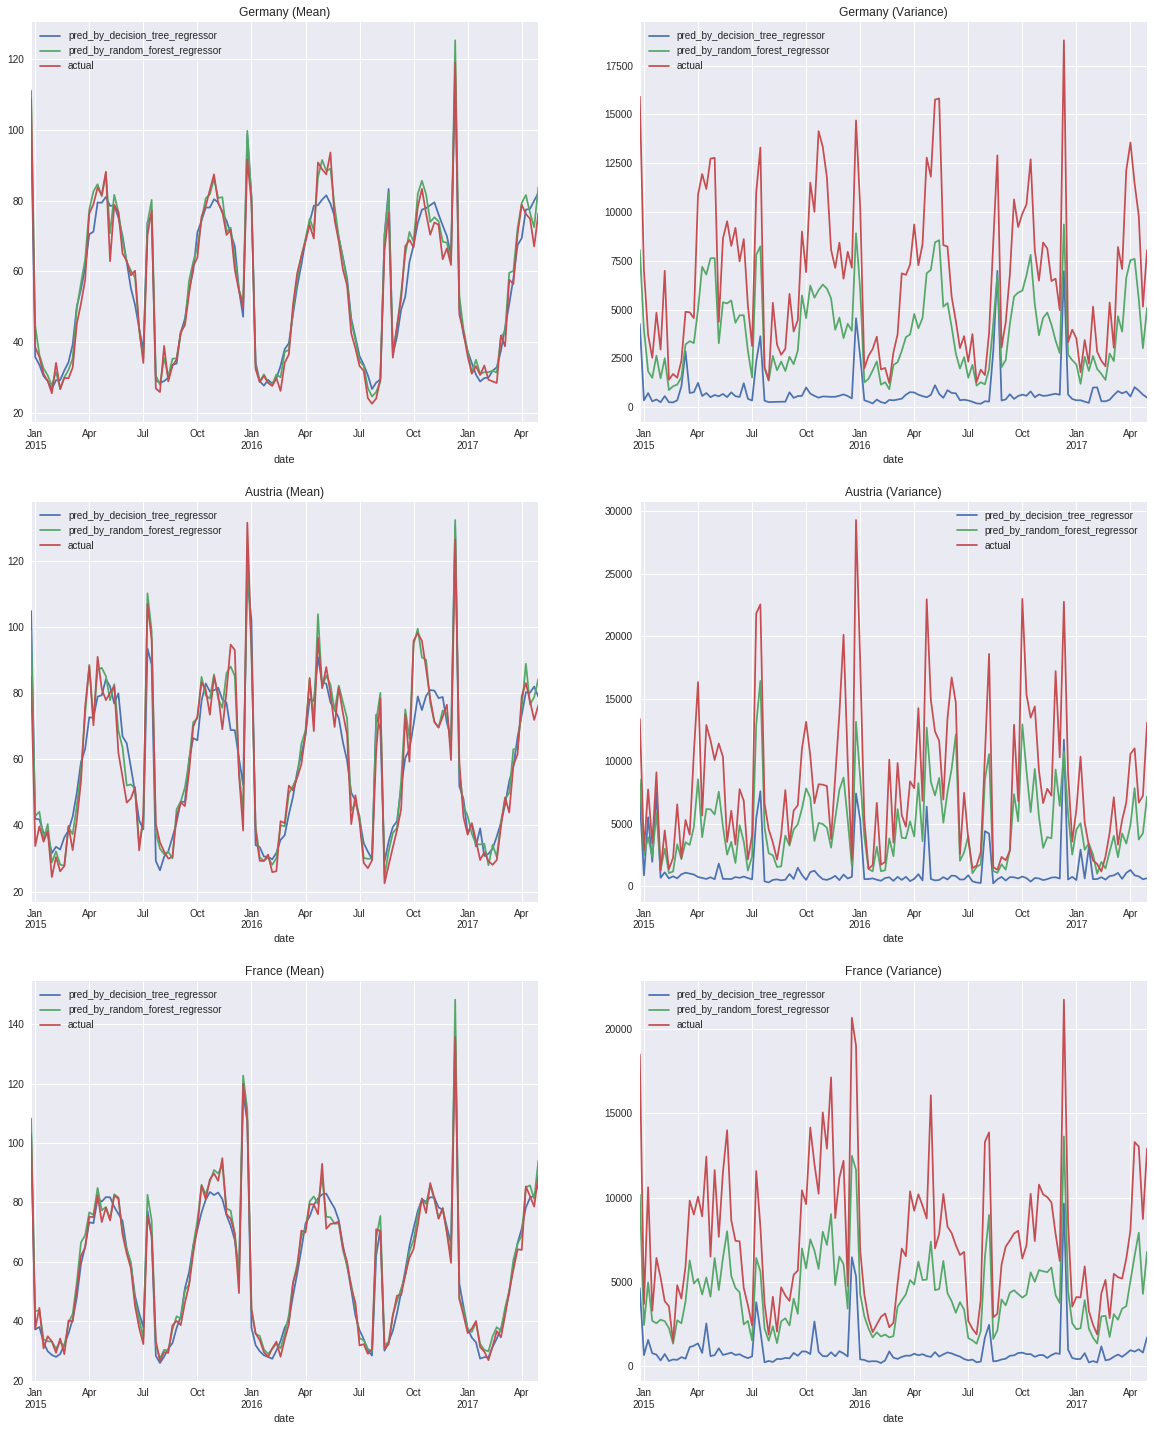

In [78]:
df = pd.DataFrame(index=df_tmp.index)
df['month'] = list(map(lambda x: x.month, df_tmp.index.date))

df['pred_by_decision_tree_regressor'] = pre_y_by_dsr
df['pred_by_random_forest_regressor'] = pre_y_by_rfr

df['country'] = df_tmp['country']
df['actual'] = Y

m = df.groupby(['country', 'date'])['pred_by_decision_tree_regressor', 'pred_by_random_forest_regressor', 'actual'].mean()
v = df.groupby(['country', 'date'])['pred_by_decision_tree_regressor', 'pred_by_random_forest_regressor', 'actual'].var()

fig, axes = plt.subplots(len(countries), 2, figsize=(20, 25)) 
for i in range(3):
    m.xs(i).plot(title = countries[i] + " (Mean)", ax = axes[i, 0])
    v.xs(i).plot(title = countries[i] + " (Variance)", ax = axes[i, 1])

    
plt.legend(loc='best')

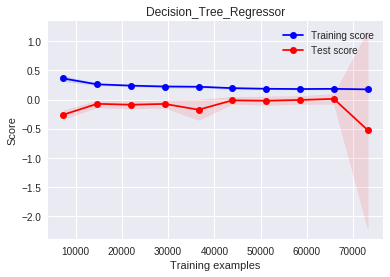

In [58]:
plot_learning_curve(dsr, "Decision_Tree_Regressor")

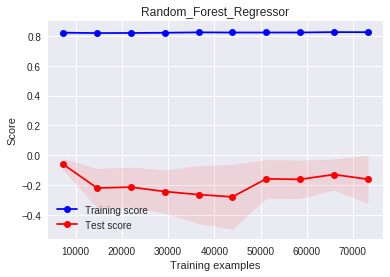

In [59]:
plot_learning_curve(rfr, "Random_Forest_Regressor")